相關內容請參閱
<a href="https://reurl.cc/GoAZ2D">分類模型評估－能夠最大化利潤的衡量指標</a>

In [1]:
#匯入基本套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn')
%matplotlib inline

In [2]:
#matplotlib圖形參數設定
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'25',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.color':'black',
         'ytick.color':'black',
         'figure.facecolor':'white'}
pylab.rcParams.update(params)

In [3]:
#設定資料路徑
#download_link: https://www.kaggle.com/kmalit/bank-customer-churn-prediction/data
data_dir = "D:\data science\kaggle\Bank Customer Churn Prediction"

In [4]:
df = pd.read_csv(data_dir + '\Churn_Modelling.csv')

In [5]:
#挑選要用的features
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

In [6]:
#將資料分為80%Training Set, 20% Testing Set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['Exited'],
    test_size = 0.2,
    random_state = 77)

In [7]:
from sklearn.linear_model import LogisticRegression

#設定LR Model
clf = LogisticRegression()

In [8]:
#用Training Set訓練模型
X_train = np.array(X_train).reshape(-1,len(features))
clf.fit(X_train,y_train)

LogisticRegression()

In [9]:
#計算特徵分數與Positive機率
def sigmoid(X):
    x = np.dot(X,clf.coef_.reshape(-1,1)) + clf.intercept_ # x = b0+b1x1+b2x2+...
    r = 1/(np.exp(-x)+1)
    return x, r

In [10]:
x, prob = sigmoid(X_train)

In [11]:
from scipy.special import expit 
#設定繪圖用變數
x_lins = np.linspace(-5,5,10000).ravel()
y_lins = expit(x_lins).ravel()
#      = 1/(np.exp(-x_lins)+1)

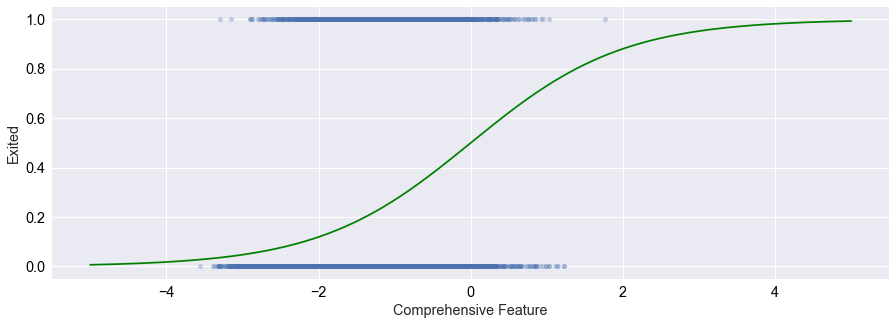

In [12]:
plt.scatter(x, y_train, alpha = 0.3, s = 20)
plt.xlabel('Comprehensive Feature')
plt.ylabel('Exited')
plt.plot(x_lins, y_lins, color = 'green')

In [13]:
#抽樣以利視覺化
rs = np.random.RandomState(77)
sample_idx = rs.choice(x.shape[0], 200, replace = False)

x_sample = x[sample_idx]
prob_sample = prob[sample_idx]
y_sample = np.array(y_train)[sample_idx]

In [14]:
#顏色設定
blue = '#2976A3'
green = '#89B3A4'
yellow = '#F8C85A'

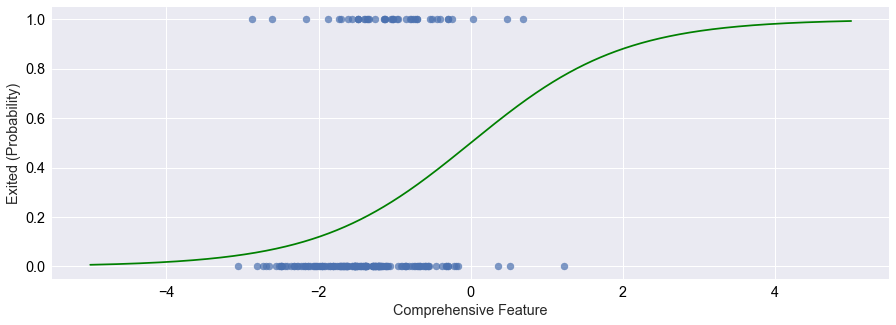

In [15]:
plt.scatter(x_sample, y_sample, alpha = 0.7, s = 50)
plt.xlabel('Comprehensive Feature')
plt.ylabel('Exited (Probability)')
plt.plot(x_lins, y_lins, color = 'green');

In [16]:
x_sam_sort = np.sort(x_sample, axis = 0)
prob_sam_sort = np.sort(prob_sample, axis = 0)

In [17]:
#畫虛線所需
d1 = [x_sam_sort[-1][0], x_sam_sort[-1][0]]
d2 = [prob_sam_sort[-1][0]-0.02, 0]

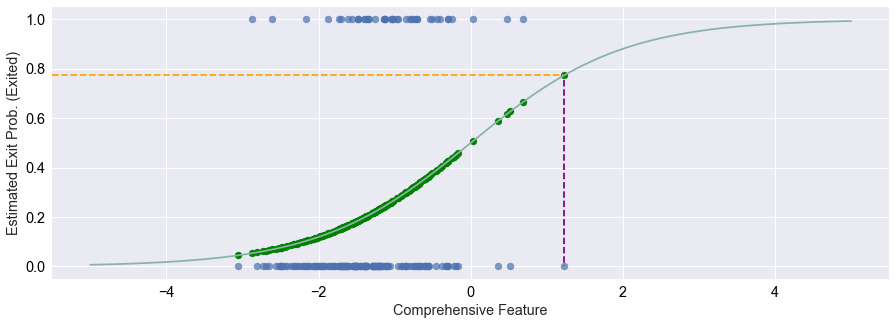

In [19]:
plt.scatter(x_sample, y_sample, alpha = 0.7, s = 50)
plt.xlabel('Comprehensive Feature')
plt.ylabel('Estimated Exit Prob. (Exited)')
plt.plot(x_lins, y_lins, color = green)
plt.scatter(x_sam_sort, prob_sam_sort, color = 'green')
plt.plot(d1,d2, ls = '--', color = 'purple')
plt.axhline(y = prob_sam_sort[-1][0], xmin=0, xmax = 0.61, ls = '--', color = 'orange');

In [20]:
colors = ['orange' if prob_sam_sort[i] > 0.5 else 'green' for i in range(x_sample.shape[0])]

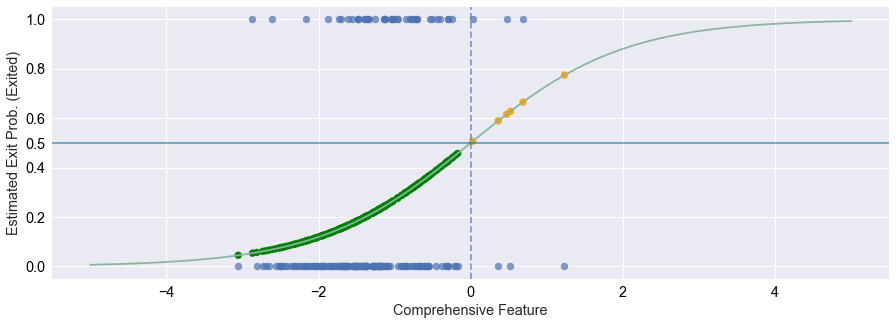

In [21]:
plt.scatter(x_sample, y_sample, alpha = 0.7, s = 50)
plt.xlabel('Comprehensive Feature')
plt.ylabel('Estimated Exit Prob. (Exited)')
plt.scatter(x_sam_sort, prob_sam_sort, color = colors)
plt.plot(x_lins, y_lins, color = green)
plt.axvline(x = 0, alpha = 0.7, ls = '--')
plt.axhline(y = 0.5, alpha = 0.7, color = blue)
plt.yticks([0,0.2,0.4,0.5,0.6,0.8,1]);

In [22]:
#不同threshold的預測結果
X_test_predict_prob = clf.predict_proba(np.array(X_test))

predict_result = {}
for _ in range(11):
    p = round(_*0.1,1)
    l = [1 if X_test_predict_prob[i][1] >= p else 0 for i in range(X_test_predict_prob.shape[0])]
    predict_result[str(p)]=l

In [23]:
predict_result.keys()

dict_keys(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])

In [24]:
def cf_matrix(prediction, true_label):
    p = prediction
    a = true_label
    
    TP = [x + y == 2 for x, y in zip(p, a)] 
    #predict = 1
    #actually = 1
    TP_count = sum(TP)

    FN = [y - x == 1 for x, y in zip(p, a)] #type II error
    #predict = 0
    #actually = 1
    FN_count = sum(FN)

    FP = [x - y == 1 for x, y in zip(p, a)] #type I error #siginificant level
    #predict = 1
    #actually = 0
    FP_count = sum(FP)
    
    TN = [x + y == 0 for x, y in zip(p, a)] 
    #predict = 0
    #actually = 0
    TN_count = sum(TN)  
    
    acc = (TP_count+TN_count)/(TP_count+FP_count+FN_count+TN_count)
    if (TP_count+FP_count) == 0:
        pre = 'no positive prediction (division by zero)'
    else:
        pre = (TP_count)/(TP_count+FP_count)
    rec = (TP_count)/(TP_count+FN_count)
    
    dict_ = {'cf_matrix': [[TP_count, FN_count], [FP_count, TN_count]], 
            'accuracy': acc, 
            'precision': pre, 
            'recall': rec}
    
    return dict_

In [25]:
cf_m5 = cf_matrix(predict_result["0.5"], y_test)['cf_matrix']
cf_m5

[[22, 378], [45, 1555]]

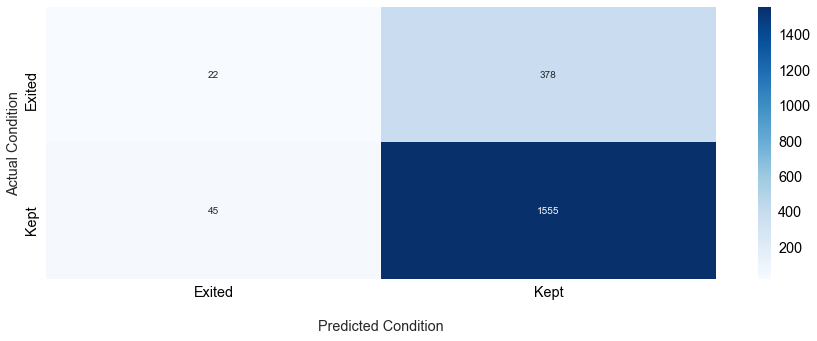

In [26]:
import seaborn as sns

ax = sns.heatmap(cf_m5, annot = True, cmap = 'Blues', fmt = 'd')

ax.set_xlabel('\nPredicted Condition')
ax.set_ylabel('Actual Condition');

ax.xaxis.set_ticklabels(['Exited','Kept'])
ax.yaxis.set_ticklabels(['Exited','Kept']);

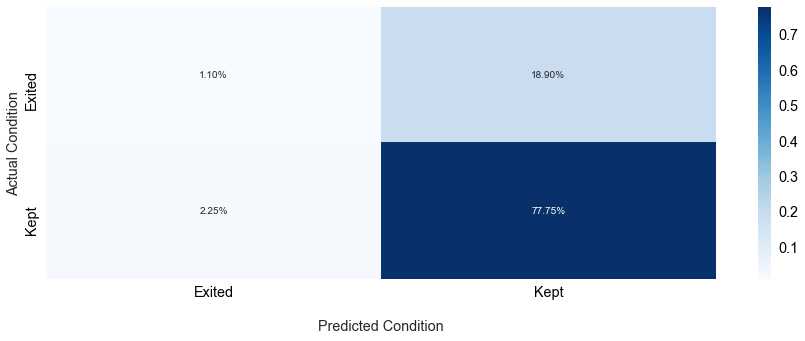

In [27]:
cf_matrix_ratio = cf_m5/np.sum(cf_m5)

ax = sns.heatmap(cf_matrix_ratio, annot = True, fmt = '.2%', cmap = 'Blues')

ax.set_xlabel('\nPredicted Condition')
ax.set_ylabel('Actual Condition');

ax.xaxis.set_ticklabels(['Exited','Kept'])
ax.yaxis.set_ticklabels(['Exited','Kept']);

In [28]:
pre_list = []
rec_list = []
pos_pred = []
for _ in range(11):
    p = round(_*0.1,1)
    key = str(p)
    
    pre_ = cf_matrix(predict_result[key], y_test)['precision']
    rec_ = cf_matrix(predict_result[key], y_test)['recall']
    
    pos_ = np.sum(cf_matrix(predict_result[key], y_test)['cf_matrix'], axis = 0)[0]
    
    pre_list.append(pre_)
    rec_list.append(rec_)
    pos_pred.append(pos_)

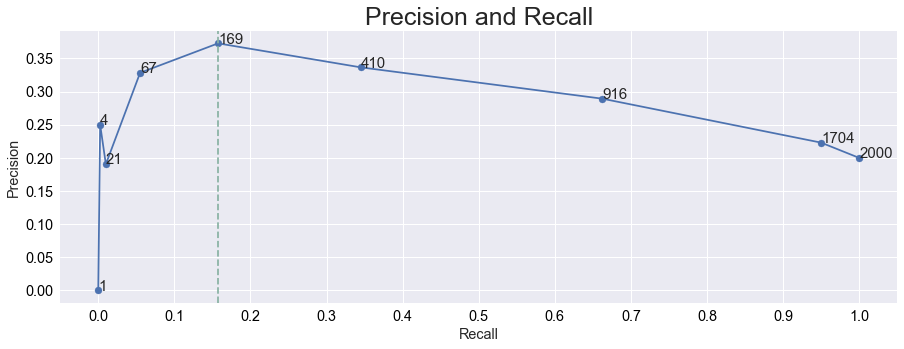

In [29]:
plt.plot(rec_list[:-2], pre_list[:-2])
plt.scatter(rec_list[:-2], pre_list[:-2])
plt.title("Precision and Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axvline(x = rec_list[4], ls = '--', color = green)
plt.xticks([round(i*0.1,1) for i in range(11)]);

for i, txt in enumerate(pos_pred[:-2]):
    plt.annotate(txt, (rec_list[:-2][i], pre_list[:-2][i]), fontsize = 15);

In [30]:
def revenue_cost(predict_result, y_test, price, keep_prob, potential_revenue, threshold):
    p = price
    kp = keep_prob
    pr = potential_revenue
    key = str(threshold)

    TP_count = cf_matrix(predict_result[key], y_test)['cf_matrix'][0][0]
    FN_count = cf_matrix(predict_result[key], y_test)['cf_matrix'][0][1]
    FP_count = cf_matrix(predict_result[key], y_test)['cf_matrix'][1][0]
    TN_count = cf_matrix(predict_result[key], y_test)['cf_matrix'][1][1]

    cost = (TP_count+FP_count)*price
    revenue = TP_count*kp*pr 
    dict_ = {'Revenue': revenue, 'Cost':cost}

    return dict_

In [31]:
rev_list = []
cost_list = []
p_list = []
profit_list = []
rev_cost_rate = []

for _ in range(11):
    p = round(_*0.1,1)
    key = p

    rc = revenue_cost(predict_result, y_test, price = 100, keep_prob = 1/5,
            potential_revenue = 2000, threshold = key)
    
    rev_list.append(rc['Revenue'])
    cost_list.append(rc['Cost'])
    p_list.append(p)
    profit_list.append(rc['Revenue']-rc['Cost'])
    if rc['Cost'] != 0:
        rev_cost_rate.append(rc['Revenue']/rc['Cost'])

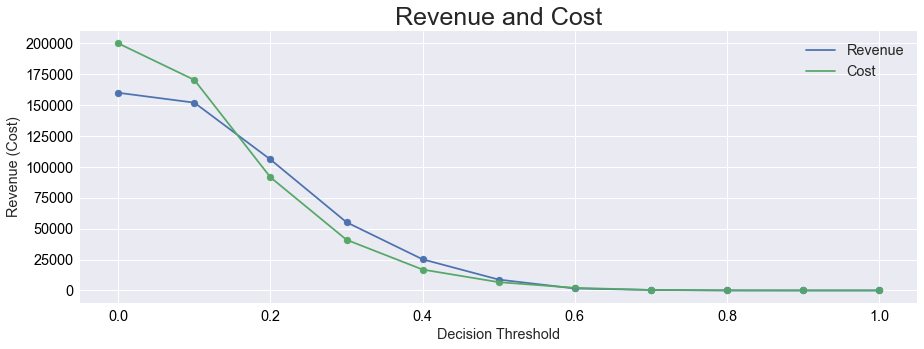

In [32]:
fig, ax1 = plt.subplots()
ax1.plot(p_list, rev_list)
ax1.plot(p_list, cost_list)
ax1.scatter(p_list, rev_list)
ax1.scatter(p_list, cost_list)
ax1.set_title("Revenue and Cost")
ax1.set_xlabel("Decision Threshold")
ax1.set_ylabel("Revenue (Cost)")
ax1.legend(['Revenue', 'Cost']);

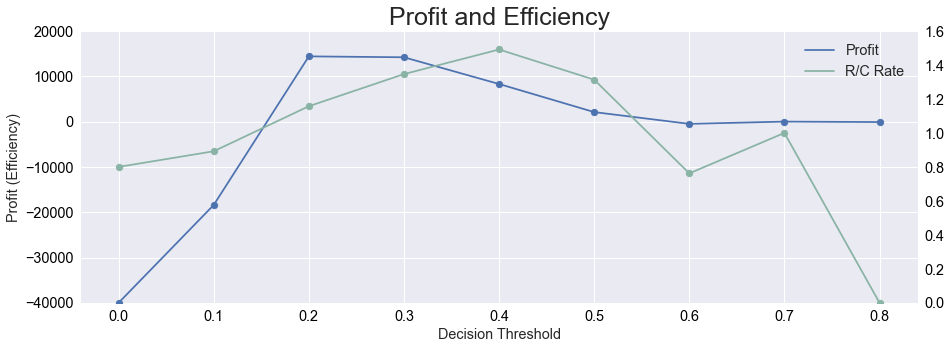

In [33]:
last = len(rev_cost_rate)

fig, ax1 = plt.subplots()
l1 = ax1.plot(p_list[:last], profit_list[:last])
ax1.scatter(p_list[:last], profit_list[:last])

ax1.set_title("Profit and Efficiency")
ax1.set_xlabel("Decision Threshold")
ax1.set_ylabel("Profit (Efficiency)")
ax1.set_ylim([-40000,20000])
# x1ticks = [-40000 + 10000*i for i in range(8)]
# ax.set_xticks(x1ticks)

ax2 = ax1.twinx()
l2 = ax2.plot(p_list[:last], rev_cost_rate[:last], color = green)
ax2.scatter(p_list[:last], rev_cost_rate[:last], color = green)
ax2.set_ylim([0.0, 1.6])
# x2ticks = [0 + 0.25*i for i in range(7)]
# ax2.set_xticks(x2ticks)
ax2.grid(None)

l1_l2 = l1 + l2
plt.legend(l1_l2,['Profit', 'R/C Rate']);